# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [2]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


In [4]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 1: Centralized Vs Federated Scenario

In this task, you will analyze the theoretical equivalence between FedSGD and a centralized training scenario. The code for both implementations has been provided. To minimize differences caused by floating-point precision, a batch size of 1 is used, along with full-batch gradient descent. You may change the device to cpu if you wish, as gpu will not be utilized for batch size of 1.

Since we are working with batch size 1 and full-batch gradient descent, accuracy is not the focus here. Instead, you will monitor gradient divergence by tracking the sum or magnitude of the gradients at each round and observe how they evolve in both settings.

Theoretically, FedSGD and centralized training should yield equivalent results. However, in this task, you may observe discrepancies. Your objective is to understand the code and identify the error that causes this divergence. You may want to review why FedSGD and full-batch centralized gradient descent are theoretically equivalent by revisiting the gradient descent steps on the global objective, as covered in class. Finally, assess whether the code aligns with these theoretical steps. If you believe they should not be equivalent, provide a reasoned justification.

In [ ]:
num_clients = 5
dirichlet_alpha = 0.8
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)

In [ ]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = 0
    for count in client_data_counts:
        total_data_count += count

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = 0
            for update in client_update_device.values():
                client_update_sum += update.abs().sum().item()
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = 0
        for update in avg_update.values():
            avg_update_sum += update.abs().sum().item()
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates



def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1} for local client")
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        # Loop over batches
        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = local_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}

    return overall_update


In [ ]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = centralized_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name]  for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = 0
        for update in epoch_update.values():
            epoch_update_sum += update.abs().sum().item()

        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates


In [ ]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [ ]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

In [ ]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

In [ ]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

# Task 2: FedAvg

Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [6]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [6]:
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    # Store average updates and accuracies for each round
    round_avg_updates = []
    round_accuracies = []

    for round_num in range(rounds):
        print(f"\nRound {round_num + 1}/{rounds}")
        client_updates = []

        # Send the global model to all clients for local training
        for client_id, train_loader in enumerate(train_loaders):
            print(f"Training on Client {client_id}")

            # Clone the global model for local training
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())

            # Perform local training
            client_update = local_train(local_model, train_loader, epochs, lr)

            # Collect the client's update
            client_updates.append(client_update)

        # Average client updates to update the global model
        global_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for client_update in client_updates:
            for name, update in client_update.items():
                global_update[name] += update / num_clients

        # Apply the averaged updates to the global model
        updated_state_dict = global_model.state_dict()
        for name, param in updated_state_dict.items():
            updated_state_dict[name] += global_update[name]
        global_model.load_state_dict(updated_state_dict)

        # Store average updates for analysis
        round_avg_updates.append(global_update)

        # Evaluate the global model after this round
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

    return round_avg_updates, round_accuracies


def local_train(model, train_loader, epochs, lr):
    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Set the model to training mode
    model.train()

    # Initialize optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Initialize overall parameter updates as zeros
    initial_params = {name: param.clone() for name, param in model.state_dict().items()}
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}

    # Perform local training
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Compute the overall parameter updates
    for name, param in model.state_dict().items():
        overall_update[name] = param - initial_params[name]

    return overall_update

In the following code you may change the learning rate or the batch size

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)



Round 1/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4

Evaluating Client 0
Client 0 Accuracy: 38.77%

Evaluating Client 1
Client 1 Accuracy: 34.66%

Evaluating Client 2
Client 2 Accuracy: 39.94%

Evaluating Client 3
Client 3 Accuracy: 39.67%

Evaluating Client 4
Client 4 Accuracy: 34.80%
Total Accuracy: 37.81%

Round 2/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4

Evaluating Client 0
Client 0 Accuracy: 60.01%

Evaluating Client 1
Client 1 Accuracy: 56.86%

Evaluating Client 2
Client 2 Accuracy: 58.13%

Evaluating Client 3
Client 3 Accuracy: 57.32%

Evaluating Client 4
Client 4 Accuracy: 48.48%
Total Accuracy: 56.25%

Round 3/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4

Evaluating Client 0
Client 0 Accuracy: 61.58%

Evaluating Client 1
Client 1 Accuracy: 59.12%

Evaluating Client 2
Client 2 Accuracy: 60

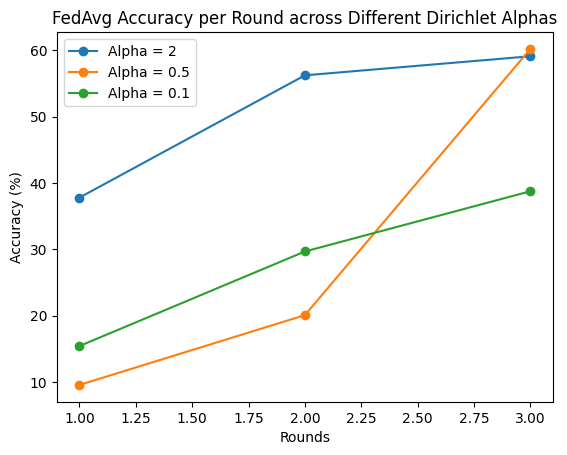

In [ ]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

### Further Exploring Effect of Label Skew

In [7]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2.0, 1.525, 1.05, 0.575, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)


Round 1/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4

Evaluating Client 0
Client 0 Accuracy: 33.00%

Evaluating Client 1
Client 1 Accuracy: 17.45%

Evaluating Client 2
Client 2 Accuracy: 36.43%

Evaluating Client 3
Client 3 Accuracy: 14.99%

Evaluating Client 4
Client 4 Accuracy: 28.87%
Total Accuracy: 24.88%

Round 2/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4

Evaluating Client 0
Client 0 Accuracy: 52.56%

Evaluating Client 1
Client 1 Accuracy: 46.87%

Evaluating Client 2
Client 2 Accuracy: 60.38%

Evaluating Client 3
Client 3 Accuracy: 37.78%

Evaluating Client 4
Client 4 Accuracy: 53.19%
Total Accuracy: 49.53%

Round 3/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4

Evaluating Client 0
Client 0 Accuracy: 62.55%

Evaluating Client 1
Client 1 Accuracy: 58.62%

Evaluating Client 2
Client 2 Accuracy: 69

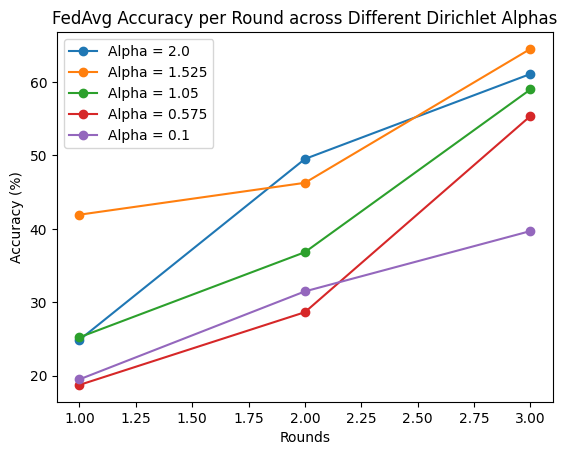

In [8]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

### 1. One Class Per Client


In [9]:
# Parameters for extreme heterogeneity
num_clients = 10  # One client per class
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001

def partition_extreme_case(train_data, train_targets, test_data, test_targets, num_clients, batch_size):
    """
    Partition data such that each client has data for only one class.
    """
    client_train_loaders = []
    client_test_loaders = []
    num_classes = len(np.unique(train_targets))
    class_indices = {c: np.where(train_targets == c)[0] for c in range(num_classes)}
    test_class_indices = {c: np.where(test_targets == c)[0] for c in range(num_classes)}

    for client_id in range(num_clients):
        assigned_class = client_id % num_classes
        train_indices = class_indices[assigned_class]
        test_indices = test_class_indices[assigned_class]

        train_data_client = torch.tensor(train_data[train_indices], dtype=torch.float32).unsqueeze(1)
        train_targets_client = torch.tensor(train_targets[train_indices], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(train_data_client, train_targets_client), batch_size=batch_size, shuffle=True)
        client_train_loaders.append(train_loader)

        test_data_client = torch.tensor(test_data[test_indices], dtype=torch.float32).unsqueeze(1)
        test_targets_client = torch.tensor(test_targets[test_indices], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(test_data_client, test_targets_client), batch_size=batch_size, shuffle=False)
        client_test_loaders.append(test_loader)

    return client_train_loaders, client_test_loaders

def run_extreme_fedavg():
    # Partition data for extreme heterogeneity
    train_loaders, test_loaders = partition_extreme_case(
        train_images / 255, train_labels, test_images / 255, test_labels, num_clients, batch_size
    )
    global_model_fedavg = SimpleCNN()

    # Run FedAvg training
    _, round_accuracies = fedavg_training(
        global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders
    )
    return round_accuracies

# Run the experiment
extreme_fedavg_accuracies = run_extreme_fedavg()


Round 1/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client 6
Training on Client 7
Training on Client 8
Training on Client 9

Evaluating Client 0
Client 0 Accuracy: 0.00%

Evaluating Client 1
Client 1 Accuracy: 77.36%

Evaluating Client 2
Client 2 Accuracy: 0.00%

Evaluating Client 3
Client 3 Accuracy: 0.00%

Evaluating Client 4
Client 4 Accuracy: 0.00%

Evaluating Client 5
Client 5 Accuracy: 51.87%

Evaluating Client 6
Client 6 Accuracy: 0.00%

Evaluating Client 7
Client 7 Accuracy: 0.00%

Evaluating Client 8
Client 8 Accuracy: 0.00%

Evaluating Client 9
Client 9 Accuracy: 0.35%
Total Accuracy: 12.97%

Round 2/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client 6
Training on Client 7
Training on Client 8
Training on Client 9

Evaluating Client 0
Client 0 Accuracy: 0.17%

Evaluating Client 1
Client

## Reflection on the Results

### Local Model Behavior:

The accuracies of individual clients vary significantly.
Some clients (e.g., Client 1 in Round 3) achieve high accuracy on their local test sets, suggesting that the local model successfully learns features specific to their assigned class.
However, most clients show poor accuracy (close to 0%), indicating that many local models fail to converge or learn meaningful representations.

### Global Model Behavior:

The global model achieves very low overall accuracy (e.g., 12.97% in Round 1, dropping further in subsequent rounds).
This indicates that aggregating highly divergent local updates in an extremely heterogeneous setting leads to a global model that struggles to generalize across classes.

## What the Local Models Learn:

Each local model, being trained only on a single class, focuses exclusively on learning features specific to that class:

### High-performing clients (e.g., Client 1):

Likely learn class-specific features effectively because their training data is homogeneous.
These models are overfitted to their class and cannot generalize beyond it.

### Low-performing clients (e.g., Client 0, Client 2, etc.):

May fail to converge due to the limited data volume or poor initialization.
These models might not learn even the specific features of their assigned class effectively.

## Why the Local Models Struggle

### Limited Data Diversity:

Each client only sees one class during training, leading to overfitting and a lack of generalizable feature learning.
Class Imbalance in Data Volume:

If some classes have fewer samples, their corresponding clients have less data to train on, causing difficulty in learning meaningful representations.

### No Exposure to Other Classes:

The lack of diverse training data prevents the models from understanding inter-class boundaries.

## Global Model Limitations

### Conflicting Updates:

FedAvg aggregates updates from clients trained on disjoint class distributions. These updates are not complementary and often conflict, leading to a diluted global model that fails to perform well on any class.

### Extreme Non-IID Data:

FedAvg assumes IID (or moderately non-IID) data distributions, which is heavily violated in this experiment. The algorithm is not designed for such extreme heterogeneity.

## Conclusion

The local models will learn features specific to their assigned class when the data volume is sufficient and training converges. However, these models:

Overfit to their single class and do not generalize.
Fail to contribute effectively to a global model in an extreme heterogeneous setting.
The global model struggles to aggregate these biased updates, resulting in poor overall performance.

# Task 3: Scaffold

In this task, you will implement the SCAFFOLD algorithm, which addresses client heterogeneity through variance reduction. We will evaluate the implementation in a 0.1 Dirichlet heterogeneous setting, and accuracy plotting code is provided.

The implementation of SCAFFOLD is similar to FedAvg, with only a few additional steps at both the server and client side. For reference, you may consult the SCAFFOLD paper to understand these adjustments in detail.

In [ ]:
def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr, mu):
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    new_c_local = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    # To Do
    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Put the model in training mode
    model.train()

    # Move c_global and c_local to the device
    c_global = {name: tensor.to(device) for name, tensor in c_global.items()}
    c_local = {name: tensor.to(device) for name, tensor in c_local.items()}

    # Declare the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Initialize the initial model parameters
    initial_params = {name: param.clone() for name, param in model.state_dict().items()}

     # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        tqdm_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (images, labels) in tqdm_bar:
            # Sedning the images and labesl to the appropriate device
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Applying the gradient correction
            for name, param in model.named_parameters():
                if param.grad is not None:
                    param.grad += mu * (c_global[name] - c_local[name])

            # Update the model parameters
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item()

            # Update tqdm bar with the current loss every 10 batches
            if batch_idx % 10 == 0:
                tqdm_bar.set_postfix({"Batch Loss": loss.item()})

        # Display the average loss for the epoch in tqdm
        tqdm_bar.set_postfix({"Epoch Loss": epoch_loss / len(train_loader)})

    # Computing the overall update
    for name, param in model.state_dict().items():
        # w_G - w_i
        overall_update[name] = param.clone() - c_local[name]
        # Updating the local control variate
        new_c_local[name] = c_local[name] - c_global[name] + mu * overall_update[name]


    return overall_update, new_c_local

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, mu):
    round_accuracies = []

    # Step 1: Initialize the global control variate
    c_global = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}

    # Step 2: Initialize local control variates for each client
    c_locals = {client_id: {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
                for client_id in range(num_clients)}

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    c_global = {name: tensor.to(device) for name, tensor in c_global.items()}  # Move c_global to device
    c_locals = {client_id: {name: tensor.to(device) for name, tensor in c_global.items()}  # Move c_locals to device
                for client_id in range(num_clients)}

    # Step 3: Federated learning rounds
    for round_num in range(rounds):
        print(f"\nRound {round_num + 1}/{rounds}")

        # Store updates and control variate deltas from clients
        client_updates = []

        # Step 4: Train on each client
        for client_id, train_loader in enumerate(train_loaders):
            print(f"Training on Client {client_id}")

            # Create a local copy of the global model
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())

            # Perform local training with SCAFFOLD
            local_update, new_c_local = local_train_scaffold(
                local_model, train_loader, c_global, c_locals[client_id], epochs, local_lr, mu
            )

            # Compute the control variate delta (c_i^+ - c_i)
            control_delta = {name: new_c_local[name] - c_locals[client_id][name]
                             for name in c_locals[client_id]}

            # Update local control variate for the client
            c_locals[client_id] = new_c_local

            # Collect updates and control deltas
            client_updates.append(local_update)

        # Step 5: Aggregate client updates for the global model
        global_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for client_update in client_updates:
            for name in global_update:
              global_update[name] += client_update[name] / num_clients

        # Apply the aggregated update to the global model
        global_state_dict = global_model.state_dict()
        for name, param in global_state_dict.items():
            global_state_dict[name] += global_update[name]
            c_global[name] += global_update[name] / num_clients

        global_model.load_state_dict(global_state_dict)

        # Step 6: Evaluate the global model on the test dataset
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

        print(f"Round {round_num + 1} Accuracy: {total_accuracy:.4f}")

    return round_accuracies

In [ ]:
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
mu = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

# Run federated SCAFFOLD with 0.1 Dirichlet and plot accuracy per round
def run_scaffold(alpha):
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size=128)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run SCAFFOLD and get accuracy per round
# scaffold_accuracies = run_scaffold()

accuracies_per_alpha_scaffold = []

for alpha in dirichlet_alphas:
    print(f"\nRunning SCAFFOLD with Dirichlet Alpha = {alpha}")
    round_accuracies_scaffold = run_scaffold(alpha)
    accuracies_per_alpha_scaffold.append(round_accuracies_scaffold)


Running SCAFFOLD with Dirichlet Alpha = 2

Round 1/3
Training on Client 0


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 37.38it/s, Batch Loss=0.106] 


Training on Client 1


Epoch 20/20: 100%|██████████| 80/80 [00:02<00:00, 28.60it/s, Batch Loss=0.178] 


Training on Client 2


Epoch 20/20: 100%|██████████| 70/70 [00:01<00:00, 35.13it/s, Batch Loss=0.135] 


Training on Client 3


Epoch 20/20: 100%|██████████| 90/90 [00:02<00:00, 35.58it/s, Batch Loss=1.05]  


Training on Client 4


Epoch 20/20: 100%|██████████| 69/69 [00:01<00:00, 36.17it/s, Batch Loss=1.74]  



Evaluating Client 0
Client 0 Accuracy: 7.54%

Evaluating Client 1
Client 1 Accuracy: 13.52%

Evaluating Client 2
Client 2 Accuracy: 2.31%

Evaluating Client 3
Client 3 Accuracy: 10.53%

Evaluating Client 4
Client 4 Accuracy: 11.48%
Total Accuracy: 9.28%
Round 1 Accuracy: 9.2833

Round 2/3
Training on Client 0


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 34.53it/s, Batch Loss=0.373]  


Training on Client 1


Epoch 20/20: 100%|██████████| 80/80 [00:02<00:00, 34.19it/s, Batch Loss=0.0844]


Training on Client 2


Epoch 20/20: 100%|██████████| 70/70 [00:02<00:00, 33.05it/s, Batch Loss=0.185]  


Training on Client 3


Epoch 20/20: 100%|██████████| 90/90 [00:02<00:00, 33.32it/s, Batch Loss=3.94]  


Training on Client 4


Epoch 20/20: 100%|██████████| 69/69 [00:02<00:00, 31.22it/s, Batch Loss=0.621]  



Evaluating Client 0
Client 0 Accuracy: 7.72%

Evaluating Client 1
Client 1 Accuracy: 13.80%

Evaluating Client 2
Client 2 Accuracy: 2.31%

Evaluating Client 3
Client 3 Accuracy: 11.02%

Evaluating Client 4
Client 4 Accuracy: 11.85%
Total Accuracy: 9.56%
Round 2 Accuracy: 9.5583

Round 3/3
Training on Client 0


Epoch 20/20: 100%|██████████| 68/68 [00:02<00:00, 32.80it/s, Batch Loss=nan]


Training on Client 1


Epoch 20/20: 100%|██████████| 80/80 [00:02<00:00, 30.59it/s, Batch Loss=970]    


Training on Client 2


Epoch 20/20: 100%|██████████| 70/70 [00:02<00:00, 31.36it/s, Batch Loss=0]      


Training on Client 3


Epoch 20/20: 100%|██████████| 90/90 [00:02<00:00, 32.57it/s, Batch Loss=0]      


Training on Client 4


Epoch 20/20: 100%|██████████| 69/69 [00:02<00:00, 33.65it/s, Batch Loss=760]    



Evaluating Client 0
Client 0 Accuracy: 7.26%

Evaluating Client 1
Client 1 Accuracy: 12.06%

Evaluating Client 2
Client 2 Accuracy: 6.24%

Evaluating Client 3
Client 3 Accuracy: 12.54%

Evaluating Client 4
Client 4 Accuracy: 10.49%
Total Accuracy: 9.95%
Round 3 Accuracy: 9.9500

Running SCAFFOLD with Dirichlet Alpha = 0.5

Round 1/3
Training on Client 0


Epoch 20/20: 100%|██████████| 75/75 [00:02<00:00, 30.25it/s, Batch Loss=0.0493]


Training on Client 1


Epoch 20/20: 100%|██████████| 75/75 [00:02<00:00, 33.25it/s, Batch Loss=0.226] 


Training on Client 2


Epoch 20/20: 100%|██████████| 54/54 [00:01<00:00, 32.41it/s, Batch Loss=0.357] 


Training on Client 3


Epoch 20/20: 100%|██████████| 82/82 [00:03<00:00, 23.99it/s, Batch Loss=1.92]  


Training on Client 4


Epoch 20/20: 100%|██████████| 92/92 [00:03<00:00, 27.30it/s, Batch Loss=0.0755]



Evaluating Client 0
Client 0 Accuracy: 0.13%

Evaluating Client 1
Client 1 Accuracy: 7.36%

Evaluating Client 2
Client 2 Accuracy: 6.11%

Evaluating Client 3
Client 3 Accuracy: 23.68%

Evaluating Client 4
Client 4 Accuracy: 5.92%
Total Accuracy: 8.96%
Round 1 Accuracy: 8.9583

Round 2/3
Training on Client 0


Epoch 20/20: 100%|██████████| 75/75 [00:02<00:00, 30.76it/s, Batch Loss=0.00941]


Training on Client 1


Epoch 20/20: 100%|██████████| 75/75 [00:02<00:00, 26.05it/s, Batch Loss=0.38]   


Training on Client 2


Epoch 20/20: 100%|██████████| 54/54 [00:01<00:00, 29.55it/s, Batch Loss=0.23]  


Training on Client 3


Epoch 20/20: 100%|██████████| 82/82 [00:02<00:00, 32.04it/s, Batch Loss=5.28]   


Training on Client 4


Epoch 20/20: 100%|██████████| 92/92 [00:02<00:00, 30.79it/s, Batch Loss=0.074]  



Evaluating Client 0
Client 0 Accuracy: 0.13%

Evaluating Client 1
Client 1 Accuracy: 10.82%

Evaluating Client 2
Client 2 Accuracy: 6.80%

Evaluating Client 3
Client 3 Accuracy: 25.06%

Evaluating Client 4
Client 4 Accuracy: 6.56%
Total Accuracy: 10.18%
Round 2 Accuracy: 10.1833

Round 3/3
Training on Client 0


Epoch 20/20: 100%|██████████| 75/75 [00:02<00:00, 31.02it/s, Batch Loss=0]      


Training on Client 1


Epoch 20/20: 100%|██████████| 75/75 [00:02<00:00, 33.49it/s, Batch Loss=0]      


Training on Client 2


Epoch 20/20: 100%|██████████| 54/54 [00:01<00:00, 32.04it/s, Batch Loss=0]     


Training on Client 3


Epoch 20/20: 100%|██████████| 82/82 [00:02<00:00, 33.80it/s, Batch Loss=1.75e+4]


Training on Client 4


Epoch 20/20: 100%|██████████| 92/92 [00:02<00:00, 33.86it/s, Batch Loss=0]      



Evaluating Client 0
Client 0 Accuracy: 7.66%

Evaluating Client 1
Client 1 Accuracy: 11.73%

Evaluating Client 2
Client 2 Accuracy: 13.31%

Evaluating Client 3
Client 3 Accuracy: 11.33%

Evaluating Client 4
Client 4 Accuracy: 10.68%
Total Accuracy: 10.81%
Round 3 Accuracy: 10.8083

Running SCAFFOLD with Dirichlet Alpha = 0.1

Round 1/3
Training on Client 0


Epoch 20/20: 100%|██████████| 140/140 [00:04<00:00, 29.75it/s, Batch Loss=0.00662]


Training on Client 1


Epoch 20/20: 100%|██████████| 117/117 [00:03<00:00, 31.86it/s, Batch Loss=0.0134]


Training on Client 2


Epoch 20/20: 100%|██████████| 7/7 [00:00<00:00, 27.36it/s, Batch Loss=2.5]


Training on Client 3


Epoch 20/20: 100%|██████████| 14/14 [00:00<00:00, 32.33it/s, Batch Loss=0.102]


Training on Client 4


Epoch 20/20: 100%|██████████| 99/99 [00:03<00:00, 32.84it/s, Batch Loss=0.7]    



Evaluating Client 0
Client 0 Accuracy: 11.31%

Evaluating Client 1
Client 1 Accuracy: 1.09%

Evaluating Client 2
Client 2 Accuracy: 3.35%

Evaluating Client 3
Client 3 Accuracy: 10.07%

Evaluating Client 4
Client 4 Accuracy: 29.92%
Total Accuracy: 12.76%
Round 1 Accuracy: 12.7583

Round 2/3
Training on Client 0


Epoch 20/20: 100%|██████████| 140/140 [00:05<00:00, 23.57it/s, Batch Loss=0.0201] 


Training on Client 1


Epoch 20/20: 100%|██████████| 117/117 [00:03<00:00, 30.43it/s, Batch Loss=0.000186]


Training on Client 2


Epoch 20/20: 100%|██████████| 7/7 [00:00<00:00, 32.37it/s, Batch Loss=2.54]


Training on Client 3


Epoch 20/20: 100%|██████████| 14/14 [00:00<00:00, 32.03it/s, Batch Loss=0.212]


Training on Client 4


Epoch 20/20: 100%|██████████| 99/99 [00:03<00:00, 30.10it/s, Batch Loss=0.745]  



Evaluating Client 0
Client 0 Accuracy: 14.65%

Evaluating Client 1
Client 1 Accuracy: 0.64%

Evaluating Client 2
Client 2 Accuracy: 36.36%

Evaluating Client 3
Client 3 Accuracy: 0.69%

Evaluating Client 4
Client 4 Accuracy: 15.44%
Total Accuracy: 10.35%
Round 2 Accuracy: 10.3500

Round 3/3
Training on Client 0


Epoch 20/20: 100%|██████████| 140/140 [00:05<00:00, 25.11it/s, Batch Loss=0]     


Training on Client 1


Epoch 20/20: 100%|██████████| 117/117 [00:04<00:00, 28.82it/s, Batch Loss=0]    


Training on Client 2


Epoch 20/20: 100%|██████████| 7/7 [00:00<00:00, 35.22it/s, Batch Loss=41.5]


Training on Client 3


Epoch 20/20: 100%|██████████| 14/14 [00:00<00:00, 32.57it/s, Batch Loss=0.0163]


Training on Client 4


Epoch 20/20: 100%|██████████| 99/99 [00:03<00:00, 31.54it/s, Batch Loss=3.25e+4]



Evaluating Client 0
Client 0 Accuracy: 7.42%

Evaluating Client 1
Client 1 Accuracy: 21.08%

Evaluating Client 2
Client 2 Accuracy: 1.44%

Evaluating Client 3
Client 3 Accuracy: 0.00%

Evaluating Client 4
Client 4 Accuracy: 2.16%
Total Accuracy: 9.95%
Round 3 Accuracy: 9.9500


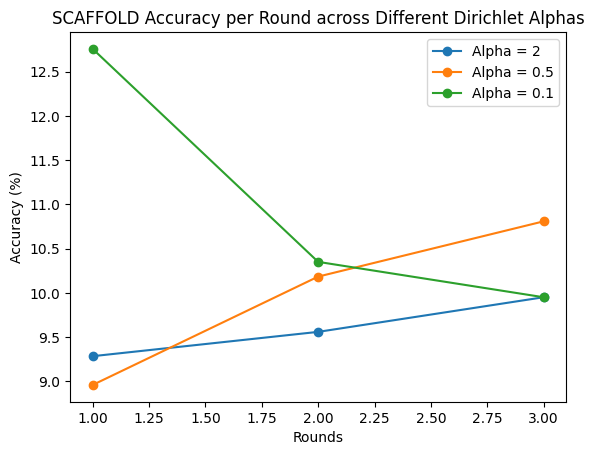

In [ ]:
# plt.figure()
# plt.plot(range(1, rounds + 1), scaffold_accuracies, marker='o', label='SCAFFOLD Alpha = 0.1')
# plt.xlabel('Rounds')
# plt.ylabel('Accuracy (%)')
# plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha = 0.1)')
# plt.legend()
# plt.show()

# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha_scaffold[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('SCAFFOLD Accuracy per Round across Different Dirichlet Alphas')
plt.show()

Exploring the effect of setting the control variate to the global control variable

In [ ]:
def federated_scaffold_modified(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
    round_accuracies = []

    # Step 1: Initialize the global control variate
    c_global = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}

    # Step 2: Initialize local control variates for each client
    c_locals = {client_id: {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
                for client_id in range(num_clients)}

    # Step 3: Federated learning rounds
    for round_num in range(rounds):
        print(f"\nRound {round_num + 1}/{rounds}")

        # Store updates and control variate deltas from clients
        client_updates = []

        # Step 4: Train on each client
        for client_id, train_loader in enumerate(train_loaders):
            print(f"Training on Client {client_id}")

            # Create a local copy of the global model
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())

            # Setting the local control variates equal to the global control variates
            c_locals[client_id] = {name: c_global[name].clone() for name in c_global}

            # Perform local training with SCAFFOLD
            local_update, new_c_local = local_train_scaffold(
                local_model, train_loader, c_global, c_locals[client_id], epochs, local_lr
            )

            # Update local control variate for the client
            c_locals[client_id] = new_c_local

            # Collect updates and control deltas
            client_updates.append(local_update)

        # Step 5: Aggregate client updates for the global model
        global_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for client_update in client_updates:
            for name, param in client_update.items():
                global_update[name] += param / num_clients

        # Apply the aggregated update to the global model
        global_state_dict = global_model.state_dict()
        for name, param in global_state_dict.items():
            global_state_dict[name] += local_lr * global_update[name]
        global_model.load_state_dict(global_state_dict)

        # Step 6: Evaluate the global model on the test dataset
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

        print(f"Round {round_num + 1} Accuracy: {total_accuracy:.4f}")

    return round_accuracies

Running the modified SCAFFOLD algorithm with alpha = 0.1

In [ ]:
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
mu = 0.001

# Run federated SCAFFOLD with 0.1 Dirichlet and plot accuracy per round
def run_scaffold():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size=128)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold_modified(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run SCAFFOLD and get accuracy per round
scaffold_accuracies = run_scaffold()


Round 1/3
Training on Client 0


Epoch 20/20: 100%|██████████| 33/33 [00:00<00:00, 40.83it/s, Batch Loss=0.0108]


Training on Client 1


Epoch 20/20: 100%|██████████| 113/113 [00:02<00:00, 38.73it/s, Batch Loss=3.03]  


Training on Client 2


Epoch 20/20: 100%|██████████| 151/151 [00:04<00:00, 34.88it/s, Batch Loss=0.0129]


Training on Client 3


Epoch 20/20: 100%|██████████| 45/45 [00:01<00:00, 35.25it/s, Batch Loss=0.0683]


Training on Client 4


Epoch 20/20: 100%|██████████| 35/35 [00:01<00:00, 33.31it/s, Batch Loss=0.0254]



Evaluating Client 0
Client 0 Accuracy: 5.10%

Evaluating Client 1
Client 1 Accuracy: 26.38%

Evaluating Client 2
Client 2 Accuracy: 14.99%

Evaluating Client 3
Client 3 Accuracy: 6.17%

Evaluating Client 4
Client 4 Accuracy: 2.88%
Total Accuracy: 15.47%
Round 1 Accuracy: 15.4750

Round 2/3
Training on Client 0


Epoch 20/20: 100%|██████████| 33/33 [00:00<00:00, 34.83it/s, Batch Loss=0.011]


Training on Client 1


Epoch 20/20: 100%|██████████| 113/113 [00:03<00:00, 35.18it/s, Batch Loss=3.04]  


Training on Client 2


Epoch 20/20: 100%|██████████| 151/151 [00:04<00:00, 31.24it/s, Batch Loss=0.0129]


Training on Client 3


Epoch 20/20: 100%|██████████| 45/45 [00:01<00:00, 34.31it/s, Batch Loss=0.0684]


Training on Client 4


Epoch 20/20: 100%|██████████| 35/35 [00:01<00:00, 33.33it/s, Batch Loss=0.0253]



Evaluating Client 0
Client 0 Accuracy: 4.91%

Evaluating Client 1
Client 1 Accuracy: 26.00%

Evaluating Client 2
Client 2 Accuracy: 14.47%

Evaluating Client 3
Client 3 Accuracy: 6.17%

Evaluating Client 4
Client 4 Accuracy: 2.88%
Total Accuracy: 15.13%
Round 2 Accuracy: 15.1333

Round 3/3
Training on Client 0


Epoch 20/20: 100%|██████████| 33/33 [00:00<00:00, 35.80it/s, Batch Loss=0.0112]


Training on Client 1


Epoch 20/20: 100%|██████████| 113/113 [00:03<00:00, 29.94it/s, Batch Loss=3.05]  


Training on Client 2


Epoch 20/20: 100%|██████████| 151/151 [00:04<00:00, 31.02it/s, Batch Loss=0.013] 


Training on Client 3


Epoch 20/20: 100%|██████████| 45/45 [00:01<00:00, 33.52it/s, Batch Loss=0.0685]


Training on Client 4


Epoch 20/20: 100%|██████████| 35/35 [00:01<00:00, 32.27it/s, Batch Loss=0.0252]



Evaluating Client 0
Client 0 Accuracy: 4.61%

Evaluating Client 1
Client 1 Accuracy: 25.37%

Evaluating Client 2
Client 2 Accuracy: 13.96%

Evaluating Client 3
Client 3 Accuracy: 6.10%

Evaluating Client 4
Client 4 Accuracy: 2.79%
Total Accuracy: 14.70%
Round 3 Accuracy: 14.7000


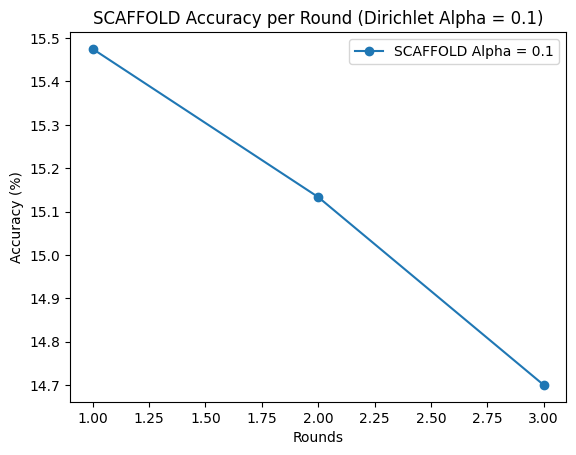

In [ ]:
plt.figure()
plt.plot(range(1, rounds + 1), scaffold_accuracies, marker='o', label='SCAFFOLD Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()

#### Theoretical Part Answers:

Suppose someone modified the SCAFFOLD algorithm so that, at the start of each communication round, each
client sets its local control variate ci equal to the global control variate c received from the server (i.e., ci = c),
instead of maintaining a client-specific ci across rounds. How would this modified version of SCAFFOLD compare
to FedAvg?

Based on the modifications suggested I believe the following will happen,

Since the global and the local control variates are the same, the equation for adjusting the model parameters becomes,

$$
w_i \leftarrow w_i - \eta \left(g_i(w_i) + c - c\right)
$$

We can see that this reduces to the equation for gradient descent as follows,

$$
w_i \leftarrow w_i - \eta \left(g_i(w_i)\right)
$$

Now since the variates are the same after the local epochs the control variate update equation at the client reduces to,

$$
c^{+}_i \leftarrow \frac{1}{K\eta} (w_G - w_i)
$$

Examining the equations this reveals that the training loop is esentially gradient descent which is the same as that of FedAVG. 

The only difference that is visible is the update of local client variate which is essentially updated based on a scaled difference between the intitial global model and the updated local model.

The following describes what these modifications acheive:

Reduction of Client Drift: In the original SCAFFOLD algorithm, $c^{+}_i$ helps counteract the client drift caused by non-IID data distributions. However, in the modified version, where $c_i = c$ this correction loses its client-specific nature.

Scaling of Updates: The update still scales the discrepancy between $w_i$ and $w_G$, but this becomes more of a global adjustment rather than a personalized correction.


# Task 4: Gradient Harmonization

In this task, you will examine how heterogeneity influences the gradient updates sent by each client. Specifically, you will analyze and quantify gradient conflicts at varying levels of heterogeneity.

First, implement the FedAvg code (You can reuse your task 2 implementation) and integrate the provided conflict-counting function at the end of each round to measure the number of conflicts in different heterogeneous settings.

Next, implement the Gradient Harmonization algorithm to harmonize conflicting gradients.

Finally, evaluate the performance of the harmonized gradients under a 0.1 Dirichlet scenario, and compare the number of conflicts before and after harmonization.

In [7]:
import builtins
sum = builtins.sum

def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

def gradient_conflict_counter(client_updates):
    total_conflicts = 0  # Variable to store the total conflicts across all layers
    num_clients = len(client_updates)

    # Iterate over each layer (key) in the client updates
    for layer_name in client_updates[0].keys():
        # Collect vectors for this layer across all clients
        layer_vectors = [client_update[layer_name].view(-1).cpu() for client_update in client_updates]

        # Check pairwise cosine similarity for this layer and count conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                sim = cosine_similarity(layer_vectors[i], layer_vectors[j])
                if sim < 0:
                    total_conflicts += 1

    print(f"Total gradient conflicts detected: {total_conflicts}")
    return total_conflicts

# Using the same local train function from the FedAVG implementation
def local_train(model, train_loader, epochs, lr):
    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Set the model to training mode
    model.train()

    # Initialize optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Initialize overall parameter updates as zeros
    initial_params = {name: param.clone() for name, param in model.state_dict().items()}
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}

    # Perform local training
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Compute the overall parameter updates
    for name, param in model.state_dict().items():
        overall_update[name] = param - initial_params[name]

    return overall_update

def Federated_gradient_conflict(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []
    conflict_counts = []
    # To Do
    for round_num in range(rounds):
        print(f"\nRound {round_num + 1}/{rounds}")
        client_updates = []

        # Send the global model to all clients for local training
        for client_id, train_loader in enumerate(train_loaders):
            print(f"Training on Client {client_id}")

            # Clone the global model for local training
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())

            # Perform local training
            client_update = local_train(local_model, train_loader, epochs, lr)

            # Collect the client's update
            client_updates.append(client_update)

        # Count gradient conflicts before averaging the updates
        total_conflicts = gradient_conflict_counter(client_updates)
        conflict_counts.append(total_conflicts)

        # Average client updates to update the global model
        global_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for client_update in client_updates:
            for name, update in client_update.items():
                global_update[name] += update / num_clients

        # Apply the averaged updates to the global model
        updated_state_dict = global_model.state_dict()
        for name, param in updated_state_dict.items():
            updated_state_dict[name] += global_update[name]
        global_model.load_state_dict(updated_state_dict)

        # Store average updates for analysis
        round_avg_updates.append(global_update)

        # Evaluate the global model after this round
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

        print(f"Round {round_num + 1} Accuracy: {total_accuracy:.4f}")
        print(f"Round {round_num + 1} Conflicts: {total_conflicts}")

    return round_avg_updates, round_accuracies, conflict_counts

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies,conflict_counts = Federated_gradient_conflict(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, conflict_counts

accuracies_per_alpha = []
conflicts_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies, conflict_counts = run_fedconflict(alpha)
    accuracies_per_alpha.append(round_accuracies)
    conflicts_per_alpha.append(conflict_counts)




Round 1/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Total gradient conflicts detected: 10

Evaluating Client 0
Client 0 Accuracy: 38.17%

Evaluating Client 1
Client 1 Accuracy: 24.36%

Evaluating Client 2
Client 2 Accuracy: 40.82%

Evaluating Client 3
Client 3 Accuracy: 26.13%

Evaluating Client 4
Client 4 Accuracy: 33.12%
Total Accuracy: 31.69%
Round 1 Accuracy: 31.6917
Round 1 Conflicts: 10

Round 2/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Total gradient conflicts detected: 2

Evaluating Client 0
Client 0 Accuracy: 57.12%

Evaluating Client 1
Client 1 Accuracy: 44.93%

Evaluating Client 2
Client 2 Accuracy: 46.77%

Evaluating Client 3
Client 3 Accuracy: 41.91%

Evaluating Client 4
Client 4 Accuracy: 45.77%
Total Accuracy: 46.82%
Round 2 Accuracy: 46.8167
Round 2 Conflicts: 2

Round 3/3
Training on Client 0
Training on Client 1
Training on Client 2
Training

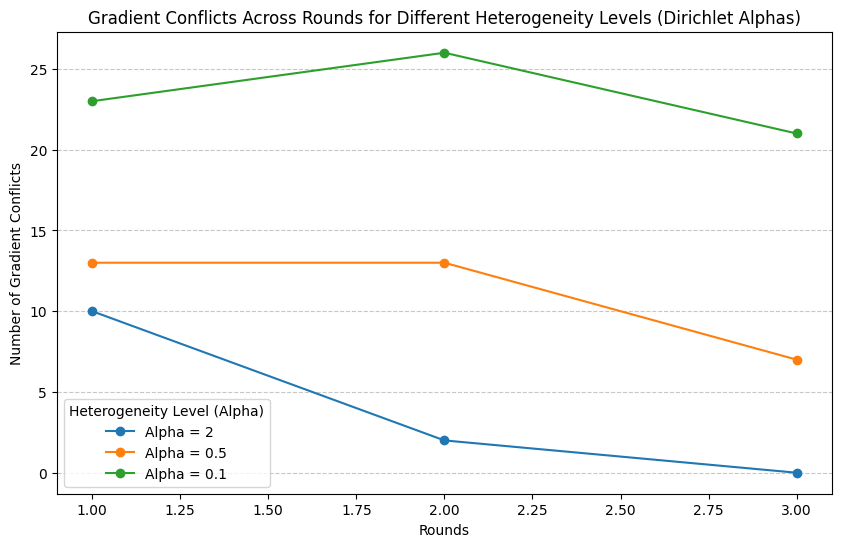

In [ ]:
plt.figure(figsize=(10, 6))

for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), conflicts_per_alpha[i], marker='o', label=f'Alpha = {alpha}')

plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [9]:
def gradient_harmonization(client_updates):
    # To Do
    # Iterate over each layer in the model
    for layer_name in client_updates[0].keys():
        # Collect all client gradients for this layer
        layer_gradients = [client_update[layer_name].view(-1).cpu() for client_update in client_updates]
        num_clients = len(layer_gradients)

        # Harmonize gradients to resolve conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                g_i = layer_gradients[i]
                g_j = layer_gradients[j]
                similarity = cosine_similarity(g_i, g_j)

                if similarity < 0:  # Conflict detected
                    # Project gradients onto each other's orthogonal plane
                    g_i -= (torch.dot(g_i, g_j) / torch.norm(g_j) ** 2) * g_j
                    g_j -= (torch.dot(g_j, g_i) / torch.norm(g_i) ** 2) * g_i

                    # Update the original client_updates
                    client_updates[i][layer_name] = g_i.view_as(client_updates[i][layer_name])
                    client_updates[j][layer_name] = g_j.view_as(client_updates[j][layer_name])

    return client_updates

def Federated_gradient_harmonization(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_accuracies = []  # List to store total accuracy after each round
    pre_harmonization_conflicts = []  # List to store conflicts before harmonization
    post_harmonization_conflicts = []  # List to store conflicts after harmonization
    # To Do
    for round_num in range(rounds):
        print(f"\nRound {round_num + 1}/{rounds}")
        client_updates = []

        # Train on each client and collect updates
        for client_id, train_loader in enumerate(train_loaders):
            print(f"Training on Client {client_id}")

            local_model = SimpleCNN()
            local_model.load_state_dict(global_model.state_dict())

            # Perform local training
            client_update = local_train(local_model, train_loader, epochs, lr)
            client_updates.append(client_update)

        # Measure conflicts before harmonization
        pre_conflicts = gradient_conflict_counter(client_updates)
        pre_harmonization_conflicts.append(pre_conflicts)

        # Harmonize gradients
        harmonized_updates = gradient_harmonization(client_updates)

        # Measure conflicts after harmonization
        post_conflicts = gradient_conflict_counter(harmonized_updates)
        post_harmonization_conflicts.append(post_conflicts)

        # Aggregate harmonized gradients to update the global model
        global_update = {name: torch.zeros_like(param) for name, param in global_model.state_dict().items()}
        for client_update in harmonized_updates:
            for name, update in client_update.items():
                global_update[name] += update / num_clients

        # Apply aggregated updates to the global model
        updated_state_dict = global_model.state_dict()
        for name, param in updated_state_dict.items():
            updated_state_dict[name] += global_update[name]
        global_model.load_state_dict(updated_state_dict)

        # Evaluate the global model after this round
        _, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

        print(f"Round {round_num + 1} Accuracy: {total_accuracy:.4f}")
        print(f"Conflicts: Pre-Harmonization {pre_conflicts}, Post-Harmonization {post_conflicts}")

    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts


In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
alpha = 0.1

# Run federated gradient harmonization
train_loaders, test_loaders, _, _ = partition_data(
    train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size
)
global_model_fedavg = SimpleCNN()
round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = Federated_gradient_harmonization(
    global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders
)


Round 1/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Total gradient conflicts detected: 19
Total gradient conflicts detected: 9

Evaluating Client 0
Client 0 Accuracy: 12.86%

Evaluating Client 1
Client 1 Accuracy: 13.76%

Evaluating Client 2
Client 2 Accuracy: 0.00%

Evaluating Client 3
Client 3 Accuracy: 76.85%

Evaluating Client 4
Client 4 Accuracy: 12.72%
Total Accuracy: 16.80%
Round 1 Accuracy: 16.8000
Conflicts: Pre-Harmonization 19, Post-Harmonization 9

Round 2/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Total gradient conflicts detected: 25
Total gradient conflicts detected: 9

Evaluating Client 0
Client 0 Accuracy: 57.10%

Evaluating Client 1
Client 1 Accuracy: 8.34%

Evaluating Client 2
Client 2 Accuracy: 7.37%

Evaluating Client 3
Client 3 Accuracy: 42.44%

Evaluating Client 4
Client 4 Accuracy: 19.67%
Total Accuracy: 22.95%
Round 2 Accuracy: 22.9500

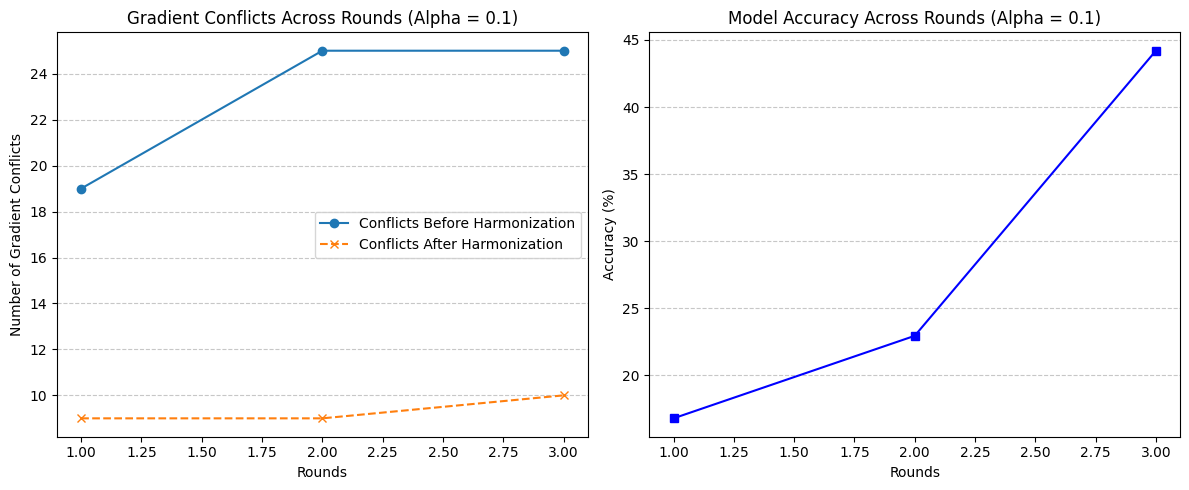

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, rounds + 1), pre_harmonization_conflicts, marker='o', linestyle='-', label='Conflicts Before Harmonization')
plt.plot(range(1, rounds + 1), post_harmonization_conflicts, marker='x', linestyle='--', label='Conflicts After Harmonization')
plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds (Alpha = 0.1)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(range(1, rounds + 1), round_accuracies, marker='s', color='b')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Across Rounds (Alpha = 0.1)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [10]:
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedGH = SimpleCNN()
    round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts  = Federated_gradient_harmonization(global_model_fedGH, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts

accuracies_per_alpha_fedGH = []
conflicts_per_alpha_fedGH = []

for alpha in dirichlet_alphas:
    print(f"\nRunning FedGH with Dirichlet Alpha = {alpha}")
    round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = run_fedconflict(alpha)
    accuracies_per_alpha_fedGH.append(round_accuracies)
    conflicts_per_alpha_fedGH.append((pre_harmonization_conflicts, post_harmonization_conflicts))
    


Running FedGH with Dirichlet Alpha = 2

Round 1/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Total gradient conflicts detected: 11
Total gradient conflicts detected: 4

Evaluating Client 0
Client 0 Accuracy: 23.59%

Evaluating Client 1
Client 1 Accuracy: 23.23%

Evaluating Client 2
Client 2 Accuracy: 29.23%

Evaluating Client 3
Client 3 Accuracy: 36.64%

Evaluating Client 4
Client 4 Accuracy: 45.92%
Total Accuracy: 31.61%
Round 1 Accuracy: 31.6083
Conflicts: Pre-Harmonization 11, Post-Harmonization 4

Round 2/3
Training on Client 0
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Total gradient conflicts detected: 0
Total gradient conflicts detected: 0

Evaluating Client 0
Client 0 Accuracy: 54.09%

Evaluating Client 1
Client 1 Accuracy: 69.85%

Evaluating Client 2
Client 2 Accuracy: 57.66%

Evaluating Client 3
Client 3 Accuracy: 57.62%

Evaluating Client 4
Client 4 Accuracy: 59.54%
Total 

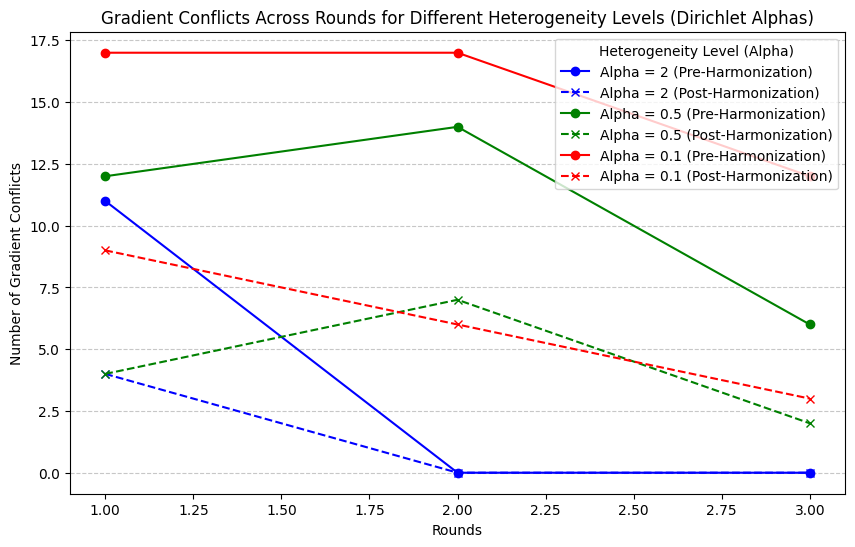

In [12]:
# Plotting the pre-harmonization and post-harmonization conflicts against different alpha values on the same graph
plt.figure(figsize=(10, 6))

colors = ['b', 'g', 'r']  # Define colors for each alpha value

for i, alpha in enumerate(dirichlet_alphas):
    pre_conflicts, post_conflicts = conflicts_per_alpha_fedGH[i]
    plt.plot(range(1, rounds + 1), pre_conflicts, marker='o', linestyle='-', color=colors[i], label=f'Alpha = {alpha} (Pre-Harmonization)')
    plt.plot(range(1, rounds + 1), post_conflicts, marker='x', linestyle='--', color=colors[i], label=f'Alpha = {alpha} (Post-Harmonization)')

plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

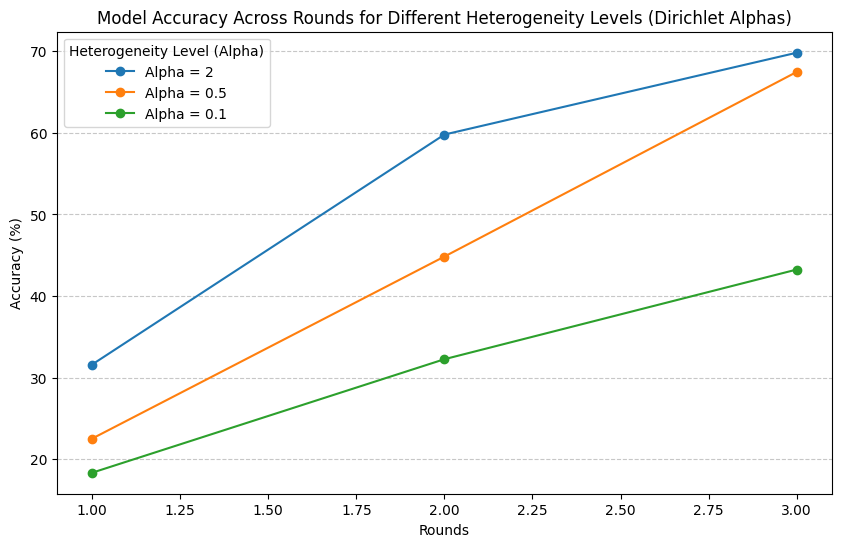

In [13]:
# Plotting the accuracy vs rounds for different alpha values
plt.figure(figsize=(10, 6))

for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha_fedGH[i], marker='o', label=f'Alpha = {alpha}')

plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

#### Thoertical Part Answers

1. Is it guaranteed that this new, harmonized gradient direction will lead to a minimization step towards the
client’s local objective? Or could it possibly increase the local objective’s loss for some clients?

No, the harmonized gradient does not guarantee a minimization step towards each client’s local objective. The primary goal of gradient harmonization is to reduce conflicts across client updates and steer the global model toward a consensus direction that balances the contributions of all clients. This may not always align with minimizing the local objective for every individual client. Since FedGH is a problem that focuses on global optimization instead of local optimization it is very likely that the local objective loss for some clients increases in order to satisfy the requirements of the global objective loss.

The following are two possible explanation for why this might occur:

Gradient Alteration: The projection step modifies the gradient direction for conflicting clients. This might reduce the component of the gradient that minimizes the local objective for a specific client in favor of improving alignment with other clients.

Trade-off Between Clients: Federated learning involves a trade-off between optimizing individual client objectives and the global objective. By harmonizing gradients, FedGH prioritizes the global objective over local objectives, which could lead to suboptimal updates for some clients.

Thus, while harmonization aims to improve overall convergence and mitigate gradient conflicts, it might increase the local loss for some clients in exchange for better global performance.

2. Consider an extreme scenario where each client’s data distribution is vastly different, causing each client to
learn a highly unique model during local training. If all clients’ gradients are heavily conflicted, how might this
affect the magnitude of the final harmonized gradient? Do you think it would be large, small, or unpredictable,
and what implications might this have on the effectiveness of the global model update?

In scenarios with highly non-IID data, where clients’ data distributions differ significantly, the harmonized gradient may become small or unpredictable in magnitude. The following explains reasons for this:

Opposing Directions: If most client gradients conflict (i.e., they point in nearly opposite directions), the projection step will remove large components of the gradients to align them. This can result in a reduction of magnitude, as much of the conflicting information is discarded.

Loss of Information: The harmonized gradient represents a compromise and may fail to capture strong signals from any individual client. This can lead to slower convergence or less effective updates to the global model.

Implications for the global model:

Smaller Gradient Magnitude:
The global update may become ineffectively small, slowing down convergence.
In extreme cases, updates could stall if the harmonization excessively suppresses gradient magnitude.

Reduced Adaptability:
In diverse datasets, the global model might fail to generalize well to all client distributions because it suppresses significant gradients from individual clients.

Potential for Bias:
Clients with gradients that align with the majority might dominate the update, while outlier clients contribute less. This could lead to a global model biased toward clients with more similar distributions.

# Task 5: FedSam

In this task, you will explore Sharpness-Aware Minimization (SAM) in a federated learning setting by implementing the FedSAM algorithm. As with previous tasks, evaluate its performance in a 0.1 Dirichlet heterogeneous scenario.

In [ ]:
def apply_sam_perturbation(local_model, criterion, x_train, y_train, rho):
    # To Do
    pass

def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    # To do
    return overall_update

def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
    round_accuracies = []
    # To Do
    return round_accuracies

In [ ]:
# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 20
lr = 0.001

def run_fedsam():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run FedSAM and get accuracy per round
sam_accuracies = run_fedsam()



In [ ]:
# Plotting accuracy per round for FedSAM with Dirichlet alpha 0.1
plt.figure()
plt.plot(range(1, rounds + 1), sam_accuracies, marker='o', label='FedSAM Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedSAM Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()